In [1]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

In [3]:
# https://drive.google.com/file/d/1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639
!gdown --id 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639
From (redirected): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639&confirm=t&uuid=5bf542a0-0da0-48f3-8e65-2375b0526313
To: /content/img_cls_scenes_classification.zip
100% 255M/255M [00:05<00:00, 45.0MB/s]


In [4]:
!unzip -q img_cls_scenes_classification.zip

In [5]:
root_dir = '/content/scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name for label_idx, class_name in enumerate(os.listdir(train_dir))
}

In [6]:
X_train = []
y_train = []
X_test = []
y_test = []

for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [7]:
seed = 0
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [8]:
class ScenesDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [9]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

In [10]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = ScenesDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)

In [11]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [12]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat([res, x], 1)

        return x


class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(* layers)

    def forward(self, x):
        return self.block(x)



In [13]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, padding=3, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        for block in self.dense_blocks:
            x = block(x)

        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [14]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet([6, 12, 24, 16], 32, n_classes).to(device)

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [16]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tValloss: {val_loss:.4f}')

    return train_losses, val_losses


In [17]:
lr = 1e-2
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)


In [18]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.4423	Valloss: 1.2557
EPOCH 2:	Train loss: 1.2114	Valloss: 1.1451
EPOCH 3:	Train loss: 1.1270	Valloss: 1.0870
EPOCH 4:	Train loss: 1.0712	Valloss: 1.0223
EPOCH 5:	Train loss: 1.0159	Valloss: 0.9673
EPOCH 6:	Train loss: 0.9705	Valloss: 0.9236
EPOCH 7:	Train loss: 0.9220	Valloss: 0.8708
EPOCH 8:	Train loss: 0.8703	Valloss: 0.8377
EPOCH 9:	Train loss: 0.8373	Valloss: 0.7972
EPOCH 10:	Train loss: 0.7940	Valloss: 0.7706
EPOCH 11:	Train loss: 0.7576	Valloss: 0.7274
EPOCH 12:	Train loss: 0.7240	Valloss: 0.7212
EPOCH 13:	Train loss: 0.6932	Valloss: 0.7122
EPOCH 14:	Train loss: 0.6596	Valloss: 0.6789
EPOCH 15:	Train loss: 0.6319	Valloss: 0.6932


In [21]:
# save model
torch.save(model.state_dict(), 'Sences_DenseNet.pth')

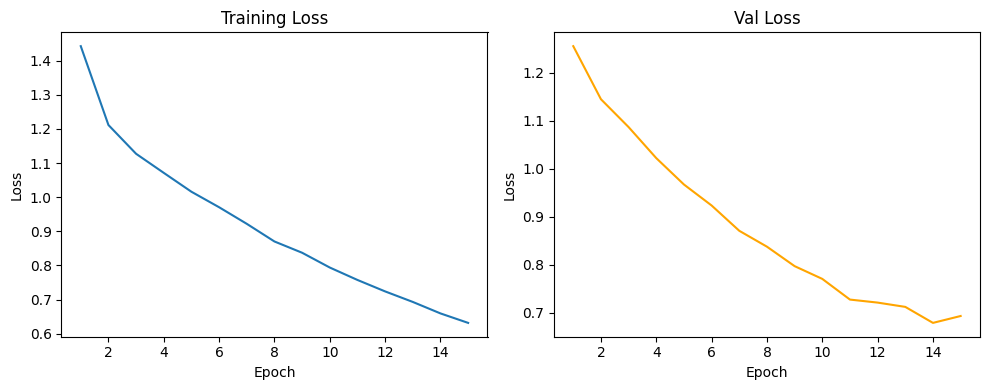

In [19]:
epochs_range = range(1, epochs + 1)

# Plotting Training and Validation Loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Training Loss
axes[0].plot(epochs_range, train_losses, color='tab:blue')
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Validation Loss
axes[1].plot(epochs_range, val_losses, color='orange')
axes[1].set_title("Val Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [20]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset ')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)


Evaluation on val/test dataset 
Val accuracy:  0.7420733879586747
Test accuracy:  0.7406666666666667
